In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import ListedColormap
from IPython.display import clear_output
from time import sleep

%matplotlib inline

In [6]:
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
cmap_light = ListedColormap(["#FFBBBB", "#BBFFBB", "#BBBBFF"])

## Activation and Helper Function

In [17]:
def linear(H):
    return H

def ReLU(H):
    return H*(H>0)

def sigmoid(H):
    return 1/(1+np.exp(-H))

def softmax(H):
    eH=np.exp(H)
    return eH/eH.sum(axis=1, keepdims=True)

def cross_entropy(Y, P_hat):
    return -(1/len(Y))*np.sum(Y*np.log(P_hat))

def one_hot_encode(y):
    N=len(y)
    K = len(set(y))
    Y=np.zeros((N,K))
    
    for i in range(N):
        Y[i,y[i]]=1
        
    return Y
def accuracy(y, y_hat):
    return np.mean(y==y_hat)

def OLS(Y,Y_hat):
    return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def R2(y,y_hat):
    return 1- np.sum((y - y_hat)**2)/np.sum((y-y.mean())**2)

def derivative (Z,a):
    if a == linear:
        return 1
    
    elif a == sigmoid:
        return Z*(1-Z)
    
    elif a==np.tanh:
        return 1-Z*Z
    
    elif a==ReLU:
        return (Z>0).astype(int)
    
    else:
        ValueError("Uknown activation Function")

In [27]:
class ANN:
    
    def __init__(self,architecture, activations = None, mode=0):
        self.mode = mode
        self.architecture = architecture
        self.activations = activations
        self.L = len(architecture)+1
        
    def fit(self, X,y, eta = 1e-3, epochs = 1e3, show_curve = False):
        
        epochs = int(epochs)
        
        if self.mode:
            Y=y
        else:
            Y=one_hot_encode(y)
            
        N,D = X.shape
        K= Y.shape[1]
        
        #Weghts and Bias initializations(random)
        
        self.W = {l: np.random.randn(M[0], M[1]) for l, M in enumerate(zip(([D]+ self.architecture),(self.architecture + [K])),1)}
        
        self.b = {l: np.random.randn(M) for l, M in enumerate(self.architecture + [K],1)}
        
        # Activation Function Loading
        
        if self.activations is None:
            self.a = {l: ReLU for l in range(1,self.L)}
        else:
            self.a = {l: act for l, act in enumerate(self.activations, 1)}
            
        
        
        # Mode Set
        
        if self.mode:
            self.a[self.L]=linear
        else:
            self.a[self.L]=softmax
            
        J = np.zeros(epochs)
        
        # Gradient Descent:
        
        for epoch in range(epochs):
            self.forward(X)
            
            if self.mode:
                J[epoch]=OLS(Y, self.Z[self.L])
            else:
                J[epoch]= cross_entropy(Y,self.Z[self.L])
                
            dH = (1/N)*(self.Z[self.L]-Y)
            
            # Weight and Bias Update Rules
            
            for l in sorted(self.W.keys(), reverse = True):
                
                dW = self.Z[l-1].T@dH
                db = dH.sum(axis=0)
                
                self.W[l] -= eta*dW
                self.b[l] -= eta*db
                
                if l > 1:
                    dZ = dH@self.W[l].T
                    dH = dZ*derivative(self.Z[l-1], self.a[l-1])
                    
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Training Curve")
            plt.show()

    def forward(self,X):
        self.Z={0:X}
        
        for l in sorted(self.W.keys()):
            self.Z[l]=self.a[l](self.Z[l-1]@self.W[l]+self.b[l])
    
    def predict(self, X):
        self.forward(X)
        
        if self.mode:
            return self.Z[self.L]
        else:
            return self.Z[self.L].argmax(axis=1)


In [28]:
def main():
    D = 2
    K = 3
    N = int(K*1e3)
    
    X0 = np.random.randn((N//K),D) + np.array([2,2])
    X1 = np.random.randn((N//K),D) + np.array([0,-2])
    X2 = np.random.randn((N//K),D) + np.array([-2,2])
    X = np.vstack((X0,X1,X2))
    
    y = np.array([0]*(N//K) + [1]*(N//K) + [2]*(N//K))
    
    myAnn = ANN([8,8,8], [ReLU, np.tanh, np.tanh])
    myAnn.fit(X,y, eta=3e-2, epochs=2e3, show_curve=True)
    y_hat = myAnn.predict(X)
    
    print(f"Training Accuracy: {accuracy(y,y_hat):0.4f}")
          
    x1 = np.linspace(X[:,0].min() -1, X[:,0].max(), 1000)
    x2 = np.linspace(X[:,1].min() -1, X[:,1].max(), 1000)
    
    xx1,xx2 = np.meshgrid(x1,x2)
    Z = myAnn.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=y, cmap=cmap_bold)
    plt.title(" Data ")
    
    plt.figure()
    plt.scatter(X[:,0],X[:,1],c=y_hat, cmap=cmap_bold)
    plt.title(" Prediction ")
    plt.pcolormesh(xx1,xx2,Z, cmap=cmap_light)
    plt.show()

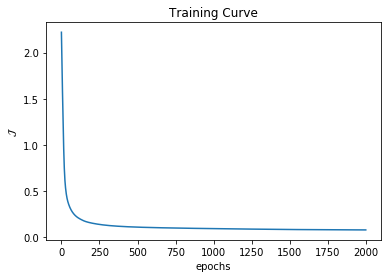

Training Accuracy: 0.9753


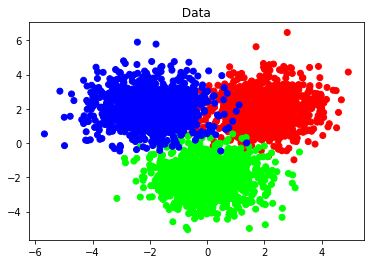

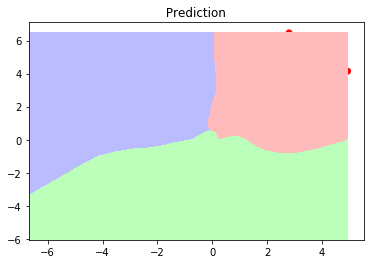

In [29]:
if  __name__ == "__main__":
    main()